### Test the scarlet measurement completeness.
Do this on $gpfs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP
from kuaizi.utils import padding_PSF
from kuaizi.detection import Data
from kuaizi import HSC_pixel_scale, HSC_zeropoint

import sep

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, vstack
from astropy.coordinates import SkyCoord
from astropy.utils.data import download_file, clear_download_cache

In [3]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.utils.set_matplotlib(style='default', usetex=False)

In [4]:
TIGRESS = '/tigress/jiaxuanl/Data/HSC/LSBG'

In [5]:
## Initialize `unagi`
from unagi import hsc, config
from unagi import plotting
from unagi.task import hsc_cutout, hsc_psf

s18a = hsc.Hsc(dr='dr2', rerun='s18a_wide')

# Get table list from /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/unagi-0.1.3.dev13-py3.7.egg/unagi/data/s18a_wide/s18a_wide_tables.fits


In [6]:
from kuaizi.mock import Data, MockGal
import galsim

In [20]:
np.random.seed(123)
skyobj_cat = Table.read(f'{TIGRESS}/Catalog/s18a_wide_skyobject_use_meas.fits')
flag = (~skyobj_cat['g_apertureflux_57_flag'
                 ]) & (~skyobj_cat['r_apertureflux_57_flag'
                               ]) & (~skyobj_cat['i_apertureflux_57_flag'])
skyobj_cat = skyobj_cat[flag]

ind = np.random.choice(np.arange(len(skyobj_cat)), 5000)

pos_cat = skyobj_cat[ind]
pos_cat.add_column(Column(data=np.arange(0, len(pos_cat), 1)), name='index')
pos_cat.write(f'./Catalog/mock_sample/skyobj_pos_clean.fits')

In [24]:
pos_cat = Table.read(f'./Catalog/mock_sample/skyobj_pos_clean.fits', format='fits')
pos_cat['flux_radius_ave_i'] = np.ones(len(pos_cat)) * 5

pos_cat.rename_column('g_ra', 'ra')
pos_cat.rename_column('g_dec', 'dec')
pos_cat[['index', 'ra', 'dec', 'flux_radius_ave_i']].write(
    f'./Catalog/mock_sample/skyobj_pos_clean_simple.fits', overwrite=True)

In [25]:
Table.read(f'./Catalog/mock_sample/skyobj_pos_clean_simple.fits')

index,ra,dec,flux_radius_ave_i
int64,float64,float64,float64
0,148.8151411370526,0.5558082777360902,5.0
1,230.7663057084739,43.23479034952088,5.0
2,140.7767720368651,1.5157220330334473,5.0
3,145.14852148539003,-0.16696734854193288,5.0
4,187.35183014013745,0.6668031107825452,5.0
5,347.50264059914355,0.9642755274398837,5.0
6,139.69385251172721,1.7362515038803874,5.0
7,237.26946067807074,42.734681220357174,5.0
8,246.72910134462512,43.688915665907004,5.0


In [151]:
Table.read('./Catalog/mock_sample/MockBkg_cutout_cat_mock_sample.fits')['image_flag'].data.sum(axis=0)

array([975, 974, 977, 984])

Download bkg images

See `./lsbg_cutout_mock_bkg.sh`. The files are saved at `/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/mock_sample/bkg`.

## Generate mock galaxies

All flat prior

SB_eff_g: 24, 28.5

R_eff: 2 arcsec, 21 arcsec

Sersic n: 0.8, 1.2

Ellipticity: 0, 0.6

Color: [0.1, 1.2]

$$ m_{\rm tot} = \overline{\mu}_{\rm eff} - 2.5 \log(2 \pi R_e^2) $$

In [5]:
np.random.seed(42)

N_samples = 3000

SB_eff_g = np.random.uniform(24, 28.5, N_samples)
R_eff = np.random.uniform(2, 15, N_samples)
m_g = SB_eff_g - 2.5 * np.log10(2 * np.pi * R_eff**2)

sersic_n = np.random.uniform(0.8, 1.2, N_samples)
ellip = np.random.uniform(0, 0.6, N_samples)

# R_eff_sma = R_eff / np.sqrt(1 - ellip)

gi_color = np.random.normal(0.6, 0.2, N_samples)

gr_color = 0.7 * gi_color + np.random.normal(0, 0.03, N_samples)

In [10]:
param_cat = Table([Column(name='viz-id', data=np.arange(N_samples) + 2000), 
                  Column(name='SB_eff_g', data=SB_eff_g),
                  Column(name='mag_g', data=m_g), 
                  Column(name='ellip', data=ellip), 
                  Column(name='sersic_n', data=sersic_n),
                  Column(name='g-i', data=gi_color),
                  Column(name='g-r', data=gr_color),
                  Column(name='rhalf_circularized', data=R_eff),
                  ])
param_cat.write('./Catalog/mock_sample/mock_gal_param_truth_2000_5000.fits', overwrite=True)

In [15]:
vstack([Table.read('./Catalog/mock_sample/mock_gal_param_truth.fits'), 
        Table.read('./Catalog/mock_sample/mock_gal_param_truth_2000_5000.fits')]).write(
'./Catalog/mock_sample/mock_gal_param_truth_0_5000.fits', overwrite=False)

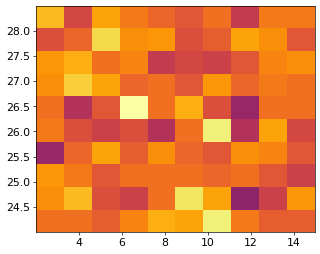

In [7]:
plt.hist2d(R_eff, SB_eff_g, vmin=0);

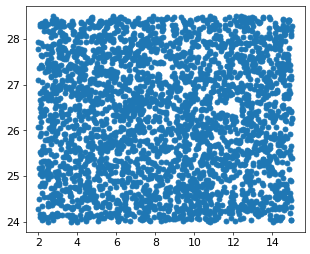

In [8]:
plt.scatter(R_eff, SB_eff_g)

[<AxesSubplot:title={'center':'Background'}>,
 <AxesSubplot:title={'center':'Mock Image'}>,
 <AxesSubplot:title={'center':'Model'}>]

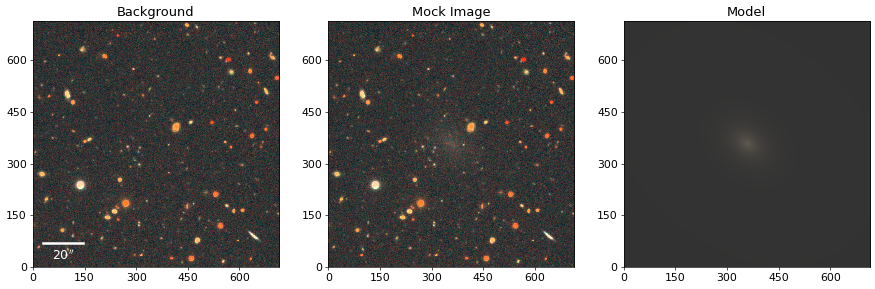

In [20]:
import pickle
with open('./Cutout/mock_sample/mock_2003.pkl', 'rb') as fp:
    gal = pickle.load(fp)
    
gal.display()

### Merge catalogs

In [42]:
mock_cat = Table.read('./Catalog/mock_sample/mock_obj_cat_4000_5000.fits')

In [43]:
mock_cat[:2000] = Table.read('./Catalog/mock_sample/mock_obj_cat_0_2000.fits')

In [44]:
import pickle
from tqdm import trange

In [45]:
channels = 'griz'

In [46]:
for ind in trange(2000, 5000):
    try:
        with open(f'./Cutout/mock_sample/mock_{ind}.pkl', 'rb') as fp:
            mgal = pickle.load(fp)

        mock_cat[ind]['viz-id'] = ind
        mock_cat[ind]['ra'] = mgal.mock.info['ra']
        mock_cat[ind]['dec'] = mgal.mock.info['dec']
        mock_cat[ind]['mag_auto_i'] = mgal.mock.info['imag']

        model_dict = mgal.model.info['comp'][0]
        mock_cat[ind]['sersic_n'] = model_dict['model_params']['n']
        mock_cat[ind]['sersic_rhalf_circ'] = model_dict['model_params']['half_light_radius']
        mock_cat[ind]['sersic_ell'] = 1 - model_dict['shear_params']['q']
        mock_cat[ind]['sersic_PA'] = model_dict['shear_params']['beta'].deg
        mock_cat[ind]['sersic_sed'] = model_dict['sed']
        mock_cat[ind]['mags'] = [mgal.mock.info[f'{filt}mag']
                       for filt in list('griz')]
        mock_cat[ind]['prefix'] = f'./Cutout/mock_sample/mock_{mock_cat[ind]["viz-id"]}'
    except:
        mock_cat[ind]['viz-id'] = ind
        mock_cat[ind]['ra'] = np.nan
        mock_cat[ind]['dec'] = np.nan
        mock_cat[ind]['mag_auto_i'] = np.nan
        mock_cat[ind]['sersic_n'] = np.nan
        mock_cat[ind]['sersic_rhalf_circ'] = np.nan
        mock_cat[ind]['sersic_ell'] = np.nan
        mock_cat[ind]['sersic_PA'] = np.nan
        mock_cat[ind]['sersic_sed'] = np.ones(len(channels)) * np.nan
        mock_cat[ind]['mags'] = np.ones(len(channels)) * np.nan
        mock_cat[ind]['prefix'] = ''

100%|██████████| 3000/3000 [02:18<00:00, 21.69it/s]


In [49]:
image_flag = []
for obj in mock_cat:
    image_flag.append(
        [os.path.isfile(f"{obj['prefix']}_{filt}.fits") for filt in channels])
mock_cat['image_flag'] = image_flag

psf_flag = []
for obj in mock_cat:
    psf_flag.append(
        [os.path.isfile(f"{obj['prefix']}_{filt}_psf.fits") for filt in channels])
mock_cat['psf_flag'] = psf_flag

# lsbg_cat.write(
#     f'./Catalog/mock_sample/mock_obj_cat_{low}_{high}.fits', overwrite=True)


In [54]:
np.sum(~np.all(mock_cat['psf_flag'].data, axis=1))

81

In [55]:
mock_cat.write(
    f'./Catalog/mock_sample/mock_obj_cat_0_5000.fits', overwrite=True)